# Popularity of Schlager Music

## Research Questions
"To what extent has the popularity of Schlager artists in Austria increased from 2008 to 2024?"
*	“Are Schlager songs with Collaborations more popular than feature-less Schlager Songs?”
*	“Do songs increase in popularity after certain televised events?”
## Motivation
*	Schlager is a culturally significant genre in German-speaking countries, known for its catchy melodies and nostalgic themes.
*	This project can reveal trends in musical tastes, the impact of cultural events, and the longevity of artists' popularity.
## Background
*	Use weekly global charts from January 2008 onwards to track changes in Schlager artist popularity.
*	Identify collaborations of schlager artists.


## Import Data & Libraries

In [1]:
!pip3 install python-louvain

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
import networkx as nx
from itertools import combinations
from matplotlib.colors import ListedColormap
import community as community_louvain

In [3]:
# Spotify API credentials
client_id = "4a5d601ff9e649a7912a92fd1754e733"
client_secret = "963527c72c4643b99a03679e61ddbdec"

# Get access token
auth_response = requests.post(
    "https://accounts.spotify.com/api/token",
    {
        "grant_type": "client_credentials",
        "client_id": client_id,
        "client_secret": client_secret,
    },
)
access_token = auth_response.json()["access_token"]
headers = {"Authorization": f"Bearer {access_token}"}

# Function to get Schlager tracks for a given year
def get_schlager_tracks_by_year(year):
    response = requests.get(
        "https://api.spotify.com/v1/search",
        headers=headers,
        params={"q": f"genre:schlager year:{year}", "type": "track", "limit": 50},
    )
    data = response.json()
    tracks = [
        {
            "name": track["name"],
            "artist": ", ".join(artist["name"] for artist in track["artists"]),
            "popularity": track["popularity"],
            "release_date": track["album"]["release_date"],
        }
        for track in data["tracks"]["items"]
    ]
    return tracks

# Collect tracks from 2008 (spotify launched that year) to 2024
all_tracks = []
for year in range(2008, 2025):
    print(f"Fetching Schlager tracks for {year}...")
    all_tracks.extend(get_schlager_tracks_by_year(year))

# Save results or analyze
print(f"Collected {len(all_tracks)} tracks.")

Fetching Schlager tracks for 2008...
Fetching Schlager tracks for 2009...
Fetching Schlager tracks for 2010...
Fetching Schlager tracks for 2011...
Fetching Schlager tracks for 2012...
Fetching Schlager tracks for 2013...
Fetching Schlager tracks for 2014...
Fetching Schlager tracks for 2015...
Fetching Schlager tracks for 2016...
Fetching Schlager tracks for 2017...
Fetching Schlager tracks for 2018...
Fetching Schlager tracks for 2019...
Fetching Schlager tracks for 2020...
Fetching Schlager tracks for 2021...
Fetching Schlager tracks for 2022...
Fetching Schlager tracks for 2023...
Fetching Schlager tracks for 2024...
Collected 850 tracks.


In [5]:
# Convert the list of dictionaries to a DataFrame
spotify_data_schlager_over_time = pd.DataFrame(all_tracks)

# Display the first few rows
spotify_data_schlager_over_time.head()

,name,artist,popularity,release_date
0,Sweet Caroline - Single Version,DJ Ötzi,57,2008
1,Ein Bett Im Kornfeld,Jürgen Drews,52,2008-10-17
2,1000 und 1 Nacht - Remastered 2008,Klaus Lage,54,2008-01-01
3,Eine neue Liebe ist wie ein neues Leben,Jürgen Marcus,50,2008-10-11
4,"Irgendwann, Irgendwo, Irgendwie",Jürgen Drews,45,2008-10-17


## Cleaning of Data

In [6]:
# Apply this function to detect years (4-digit format) and convert them into complete dates
def fix_incomplete_dates(x):
    x = str(x)
    if len(x) == 4 and x.isdigit():  # Check if the value is a year
        return x + "-01-01"  # Add a default month and day
    return x  # Return the date as it is if it's not just a year

# Apply this function to the release_date column
spotify_data_schlager_over_time["release_date"] = spotify_data_schlager_over_time["release_date"].apply(fix_incomplete_dates)

# Convert the release_date to datetime again
spotify_data_schlager_over_time["release_date"] = pd.to_datetime(spotify_data_schlager_over_time["release_date"], errors="coerce")

# Extract the release year
spotify_data_schlager_over_time["release_year"] = spotify_data_schlager_over_time["release_date"].dt.year.astype("Int64")

# Display the cleaned DataFrame
spotify_data_schlager_over_time.head()

,name,artist,popularity,release_date,release_year
0,Sweet Caroline - Single Version,DJ Ötzi,57,2008-01-01,2008
1,Ein Bett Im Kornfeld,Jürgen Drews,52,2008-10-17,2008
2,1000 und 1 Nacht - Remastered 2008,Klaus Lage,54,2008-01-01,2008
3,Eine neue Liebe ist wie ein neues Leben,Jürgen Marcus,50,2008-10-11,2008
4,"Irgendwann, Irgendwo, Irgendwie",Jürgen Drews,45,2008-10-17,2008


## Analysing

### Average Popularity of Schlager per year

In [7]:
mean_popularity_per_year = spotify_data_schlager_over_time.groupby("release_year")["popularity"].mean()
mean_popularity_per_year

release_year
2008    33.98
2009    34.32
2010    36.78
2011    34.30
2012    28.92
2013    36.18
2014    33.66
2015    35.72
2016    38.16
2017    40.56
2018    40.06
2019    38.24
2020    39.66
2021    41.42
2022    39.28
2023    42.50
2024    46.04
Name: popularity, dtype: float64

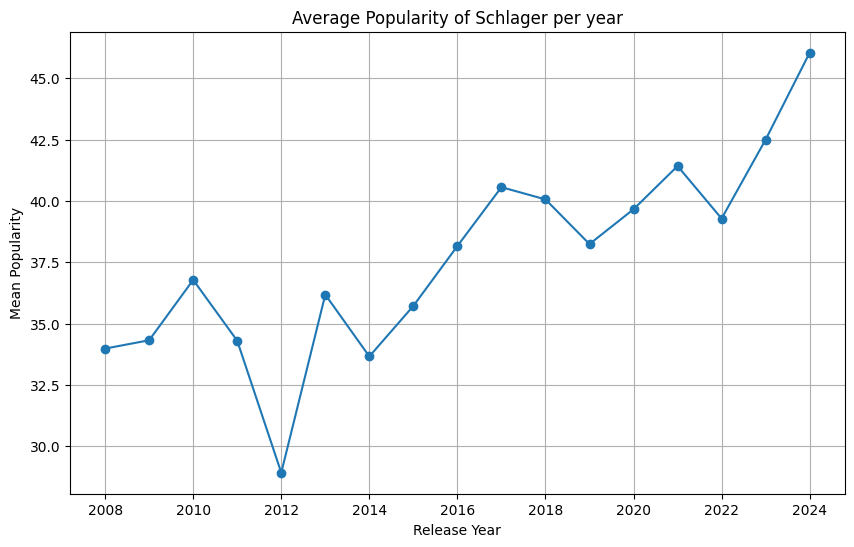

In [9]:
plt.figure(figsize=(10, 6))
mean_popularity_per_year.plot(kind='line', marker='o') #variable from above 
plt.title('Average Popularity of Schlager per year')
plt.xlabel('Release Year')
plt.ylabel('Mean Popularity')
plt.grid()
plt.savefig("data/Average Popularity of Schlager over Time.pdf", format = "pdf")

plt.show()

### Most listened Schlager Track per year

In [10]:
#artists/tracks with the highest average popularity of every year:
most_popular_tracks = spotify_data_schlager_over_time.loc[spotify_data_schlager_over_time.groupby("release_year")["popularity"].idxmax()]
most_popular_tracks

,name,artist,popularity,release_date,release_year
9,La Vie en rose,Édith Piaf,58,2008-10-13,2008
50,Ich will immer wieder... dieses Fieber spür'n,Helene Fischer,58,2009-01-01,2009
100,1000 Träume weit (Tornero),Anna-Maria Zimmermann,59,2010-01-01,2010
152,Die Hölle morgen früh,Helene Fischer,50,2011-01-01,2011
205,Hey Baby,"DJ Ötzi, The Bellamy Brothers",47,2012-01-01,2012
250,Atemlos durch die Nacht,Helene Fischer,63,2013-01-01,2013
300,Warum hast Du nicht nein gesagt - Club Mix,"Roland Kaiser, Maite Kelly",55,2014-09-12,2014
350,Hulapalu,Andreas Gabalier,60,2015-05-15,2015
400,Sieben Leben für dich,Maite Kelly,55,2016-10-14,2016
450,Herzbeben,Helene Fischer,60,2017-05-12,2017


## Top 10 Schlager Tracks from 2008 till 2024

In [11]:
top_10 = spotify_data_schlager_over_time.sort_values(by="popularity", ascending=False).head(10)

print("\n Top 10:")
top_10[["name", "artist", "popularity", "release_year"]]


 Top 10:


,name,artist,popularity,release_year
250,Atemlos durch die Nacht,Helene Fischer,63,2013
800,Handwerker,"Mickie Krause, Julian Sommer",61,2024
350,Hulapalu,Andreas Gabalier,60,2015
450,Herzbeben,Helene Fischer,60,2017
700,Der Zug hat keine Bremse - Mallorcastyle Edition,"Mia Julia, Malle Anja, Lorenz Büffel",59,2022
100,1000 Träume weit (Tornero),Anna-Maria Zimmermann,59,2010
50,Ich will immer wieder... dieses Fieber spür'n,Helene Fischer,58,2009
101,Idiot - Version 2011,"Michelle, Matthias Reim",58,2010
500,Regenbogenfarben,"Kerstin Ott, Helene Fischer",58,2018
9,La Vie en rose,Édith Piaf,58,2008


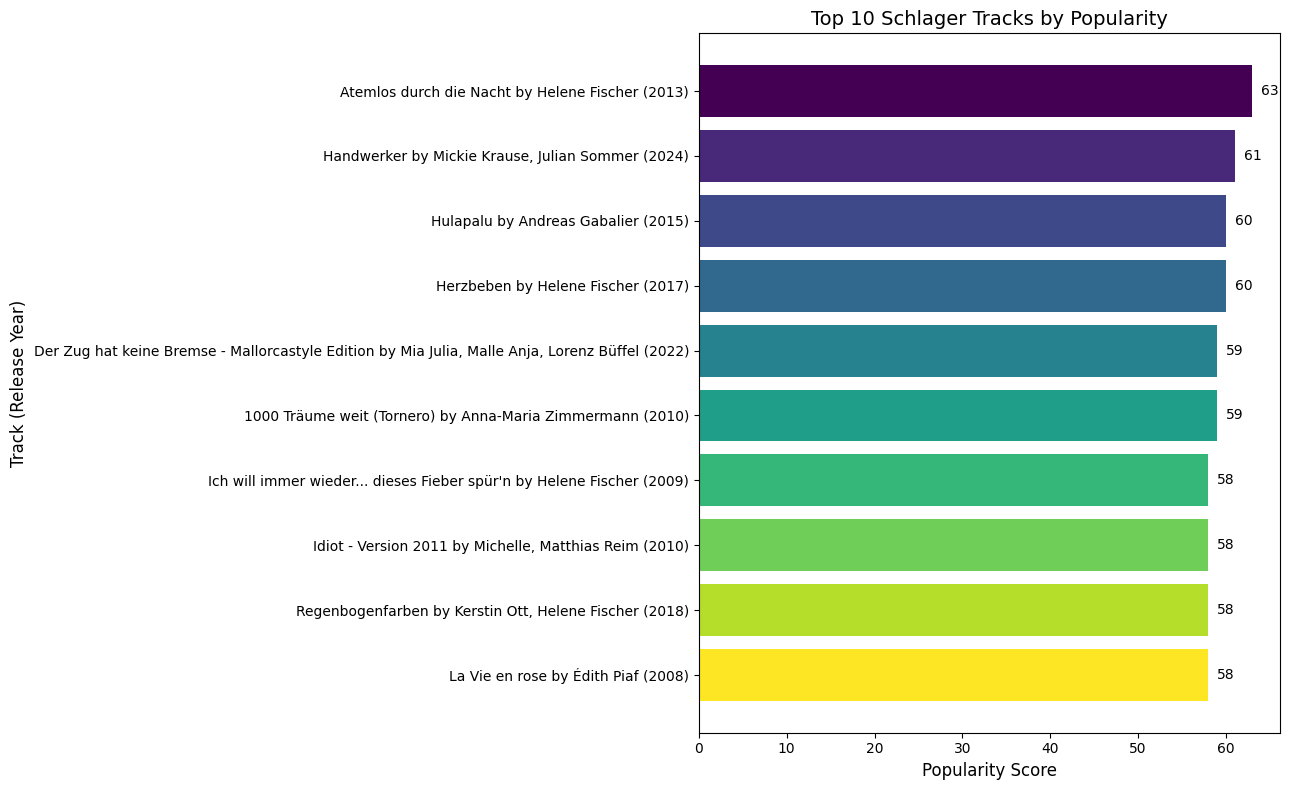

In [14]:
plt.figure(figsize=(13, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(top_10)))

# Plot horizontal bar charts
bars = plt.barh(
    top_10["name"] + " by " + top_10["artist"] + " (" + top_10["release_year"].astype(str) + ")",
    top_10["popularity"],
    color=colors  
)

plt.title("Top 10 Schlager Tracks by Popularity", fontsize=14)
plt.xlabel("Popularity Score", fontsize=12)
plt.ylabel("Track (Release Year)", fontsize=12)
plt.gca().invert_yaxis()  # Invert to have the highest score on top
plt.tight_layout()

for bar in bars:
    plt.text(
        bar.get_width() + 1,  # Position the text slightly to the right of the bar
        bar.get_y() + bar.get_height() / 2,  # Center the text vertically with the bar
        f"{int(bar.get_width())}",  # Format the text as an integer
        va="center",  # Align vertically
        fontsize=10
    )

plt.savefig("data/Top 10 Schlager Tracks by Popularity.pdf")

plt.show()

### Top 10 Artists by Schlager Song Count

In [15]:
#artist with the most tracks over the years:
artist_track_count = spotify_data_schlager_over_time.groupby('artist')['name'].count()
top_artists = artist_track_count.sort_values(ascending=False).head(10)
top_artists

artist
Helene Fischer         54
Andreas Gabalier       43
Melissa Naschenweng    31
Udo Jürgens            29
Nockis                 28
Roland Kaiser          25
Andrea Berg            20
DJ Ötzi                20
Maite Kelly            19
Semino Rossi           17
Name: name, dtype: int64

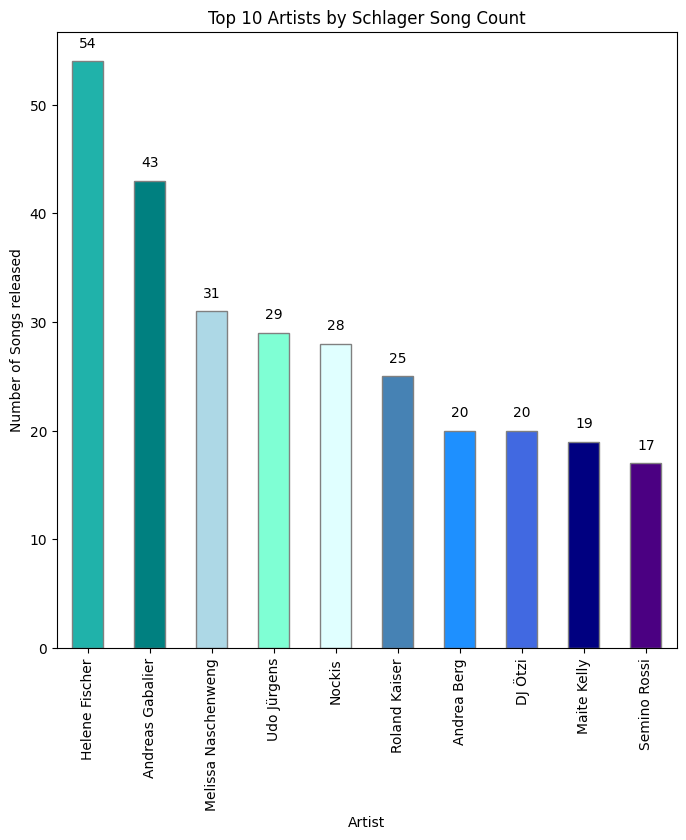

In [17]:
colors = ["lightseagreen", "teal", "lightblue", "aquamarine", "lightcyan", "steelblue", "dodgerblue", "royalblue", "navy","indigo"]

plt.figure(figsize = (8,8))
top_artists.plot(kind = "bar", color = colors, edgecolor = "grey")

plt.title("Top 10 Artists by Schlager Song Count")
plt.xlabel("Artist")
plt.ylabel("Number of Songs released")

for i, value in enumerate(top_artists):
    plt.text(i, value + 1, str(value), ha='center', va='bottom', fontsize=10)
    
plt.savefig("data/Top 10 Artists by Schlager Song Count.pdf")
plt.show()

## Networkanalysis of Collaborations of Artists

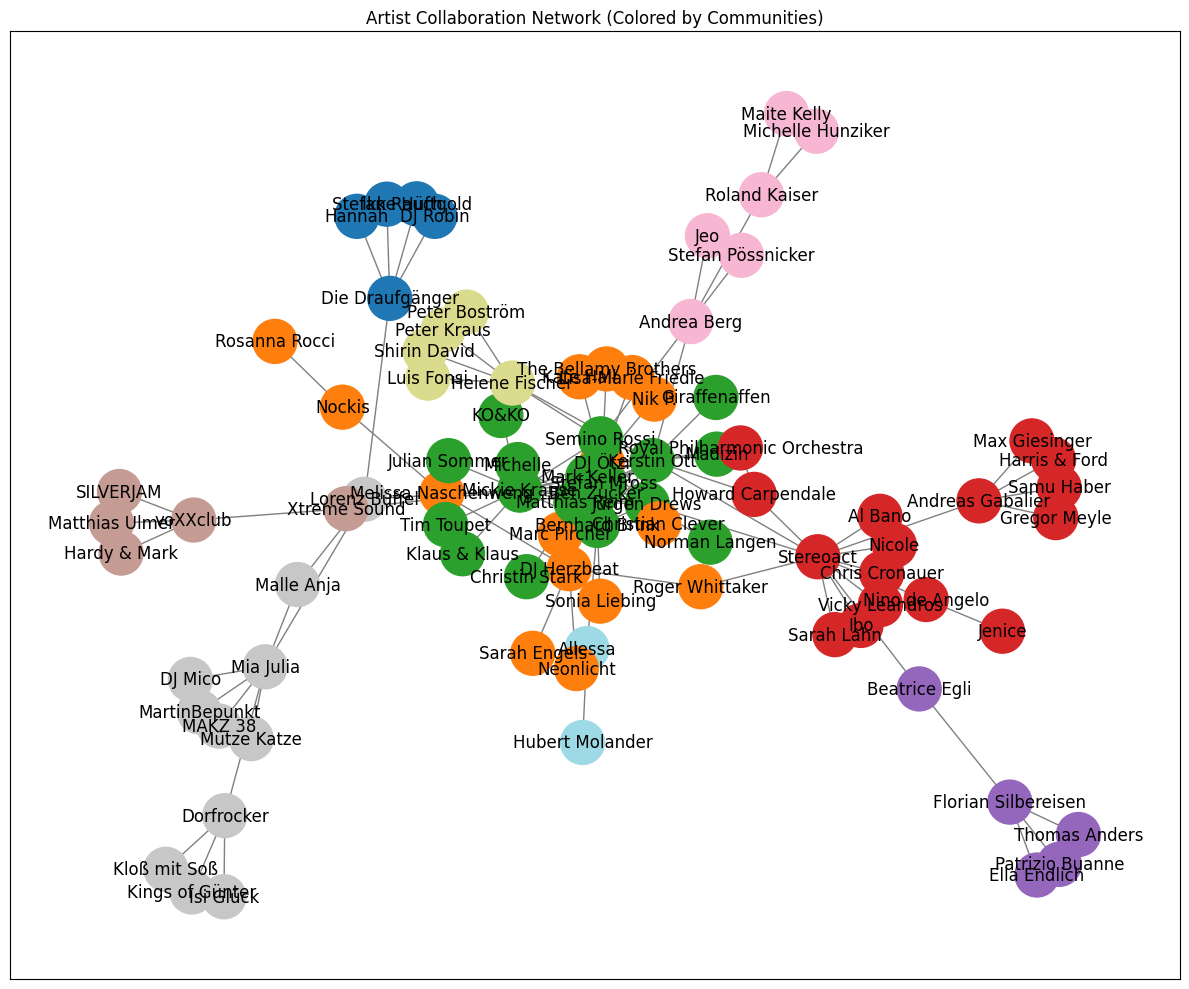

Top 10 Most Connected Artists:
DJ Ötzi: 0.1839
Kerstin Ott: 0.1839
Mickie Krause: 0.1724
Stereoact: 0.1494
Matthias Reim: 0.1379
Jürgen Drews: 0.1264
Bernhard Brink: 0.1264
Semino Rossi: 0.1264
Ben Zucker: 0.1034
Mark Keller: 0.1034


In [22]:
import matplotlib.pyplot as plt
import networkx as nx
from community import community_louvain  # Louvain method for community detection

# Ensure the data is correctly loaded
df = spotify_data_schlager_over_time.copy()

# Split artists by delimiter
df['artist_list'] = df['artist'].apply(lambda x: x.split(", "))

# Initialize a graph
G = nx.Graph()

# Add edges to the graph for each track
for _, row in df.iterrows():
    artists = row['artist_list']
    for i in range(len(artists)):
        for j in range(i + 1, len(artists)):
            G.add_edge(artists[i], artists[j])

# Ensure the graph is not empty
if G.number_of_nodes() == 0:
    raise ValueError("The graph is empty. Ensure the dataset contains valid artist collaboration data.")

# Filter nodes with degree >= 1
min_degree = 1
nodes_to_keep = [node for node, degree in dict(G.degree()).items() if degree >= min_degree]
G_filtered = G.subgraph(nodes_to_keep)

# Ensure there are connected components
if len(G_filtered) == 0:
    raise ValueError("No nodes with the specified minimum degree found in the graph.")

# Get the largest connected component
largest_cc = max(nx.connected_components(G_filtered), key=len)
G_central = G_filtered.subgraph(largest_cc)

# Detect communities using the Louvain method
partition = community_louvain.best_partition(G_central)

# Generate node colors based on community IDs
num_communities = len(set(partition.values()))
cmap = plt.get_cmap("tab20", num_communities)
node_colors = [cmap(partition[node]) for node in G_central.nodes]

# Draw the graph
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_central, seed=42)  # Layout for separation
nx.draw_networkx(
    G_central, pos,
    node_color=node_colors,
    edge_color="gray",
    node_size=1000,
    with_labels=True
)

# Add a title
plt.title("Artist Collaboration Network (Colored by Communities)")
plt.tight_layout()

# Save and show the plot
plt.savefig("data/Artist_Network_Communities.pdf", format="pdf")
plt.show()

# Analyze top collaborations
degree_centrality = nx.degree_centrality(G_central)
most_central_artists = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Most Connected Artists:")
for artist, centrality in most_central_artists:
    print(f"{artist}: {centrality:.4f}")

In [23]:
G.number_of_nodes()

142

In [24]:
print("Top 10 Most Connected Artists:")
for artist, centrality in most_central_artists:
    print(f"{artist}: {centrality:.4f}")

Top 10 Most Connected Artists:
DJ Ötzi: 0.1839
Kerstin Ott: 0.1839
Mickie Krause: 0.1724
Stereoact: 0.1494
Matthias Reim: 0.1379
Jürgen Drews: 0.1264
Bernhard Brink: 0.1264
Semino Rossi: 0.1264
Ben Zucker: 0.1034
Mark Keller: 0.1034


## Comparison of Popularity Score (Single Tracks vs Collaborations)

In [26]:
# Initialize an empty list to store the classification
multiple_artists = []

# Loop through each row in the dataset
for artist in spotify_data_schlager_over_time["artist"]:
    if "," in artist:  # Check if the artist column contains a comma
        multiple_artists.append("multiple_artists")
    else:
        multiple_artists.append("single_artist")

# Add the results to the DataFrame as a new column
spotify_data_schlager_over_time["multiple_artists"] = multiple_artists

spotify_data_schlager_over_time.head(15)

,name,artist,popularity,release_date,release_year,multiple_artists
0,Sweet Caroline - Single Version,DJ Ötzi,57,2008-01-01,2008,single_artist
1,Ein Bett Im Kornfeld,Jürgen Drews,52,2008-10-17,2008,single_artist
2,1000 und 1 Nacht - Remastered 2008,Klaus Lage,54,2008-01-01,2008,single_artist
3,Eine neue Liebe ist wie ein neues Leben,Jürgen Marcus,50,2008-10-11,2008,single_artist
4,"Irgendwann, Irgendwo, Irgendwie",Jürgen Drews,45,2008-10-17,2008,single_artist
5,Ich fang dir den Mond,Andreas Martin,43,2008-05-16,2008,single_artist
6,Noch in 100.000 Jahren - Single Version,DJ Ötzi,42,2008-01-01,2008,single_artist
7,Sie vergass zu verzeihn - Radio,Christian Lais,40,2008-02-20,2008,single_artist
8,Wir sind alle über 40 - Originalversion,Brunner & Brunner,38,2008-04-18,2008,single_artist
9,La Vie en rose,Édith Piaf,58,2008-10-13,2008,single_artist


In [27]:
popularity_comparison = spotify_data_schlager_over_time.groupby('multiple_artists')['popularity'].mean()
print(popularity_comparison)

multiple_artists
multiple_artists    40.335484
single_artist       37.031655
Name: popularity, dtype: float64


In [28]:
from scipy.stats import ttest_ind
import numpy as np

# Filter data for single and multiple artists
single_artists_popularity = spotify_data_schlager_over_time[
    spotify_data_schlager_over_time["multiple_artists"] == "single_artist"
]["popularity"]

multiple_artists_popularity = spotify_data_schlager_over_time[
    spotify_data_schlager_over_time["multiple_artists"] == "multiple_artists"
]["popularity"]

# Perform t-test for independent samples
t_stat, p_value = ttest_ind(single_artists_popularity, multiple_artists_popularity, equal_var=False)

# Output t-test results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Check significance
if p_value < 0.05:
    print("The difference in popularity scores between single and multiple artists is statistically significant (p < 0.05).")
else:
    print("No statistically significant difference in popularity scores between single and multiple artists (p >= 0.05).")

# Calculate Cohen's d for effect size
mean_single = np.mean(single_artists_popularity)
mean_multiple = np.mean(multiple_artists_popularity)
std_single = np.std(single_artists_popularity, ddof=1)  # Sample standard deviation
std_multiple = np.std(multiple_artists_popularity, ddof=1)

# Pooled standard deviation
n1 = len(single_artists_popularity)
n2 = len(multiple_artists_popularity)
pooled_std = np.sqrt(((n1 - 1) * std_single**2 + (n2 - 1) * std_multiple**2) / (n1 + n2 - 2))

cohens_d = (mean_multiple - mean_single) / pooled_std

if abs(cohens_d) < 0.2:
    effect_size = "small"
    interpretation = "The difference in popularity scores is small and might not be practically meaningful."
elif abs(cohens_d) < 0.5:
    effect_size = "medium"
    interpretation = "The difference in popularity scores is moderate and may have practical significance."
else:
    effect_size = "large"
    interpretation = "The difference in popularity scores is large and is likely to have strong practical significance."

print(f"Effect size (Cohen's d): {cohens_d:.2f} ({effect_size})")
print(f"Interpretation: {interpretation}")

T-statistic: -4.525677647297218
P-value: 9.592138508490045e-06
The difference in popularity scores between single and multiple artists is statistically significant (p < 0.05).
Effect size (Cohen's d): 0.39 (medium)
Interpretation: The difference in popularity scores is moderate and may have practical significance.


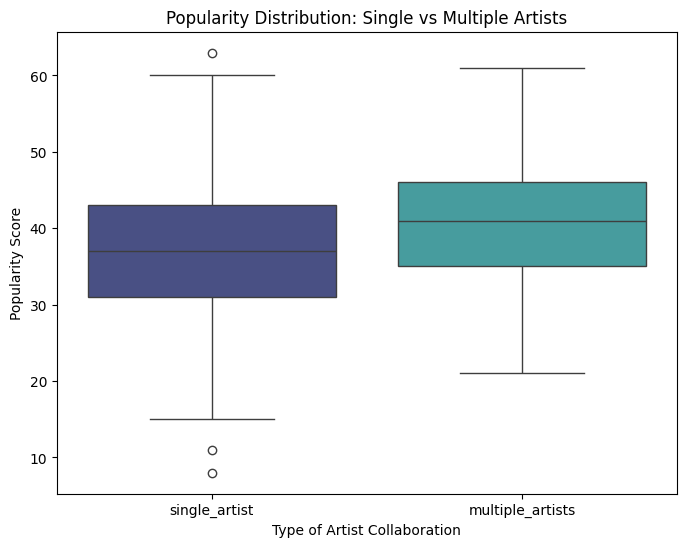

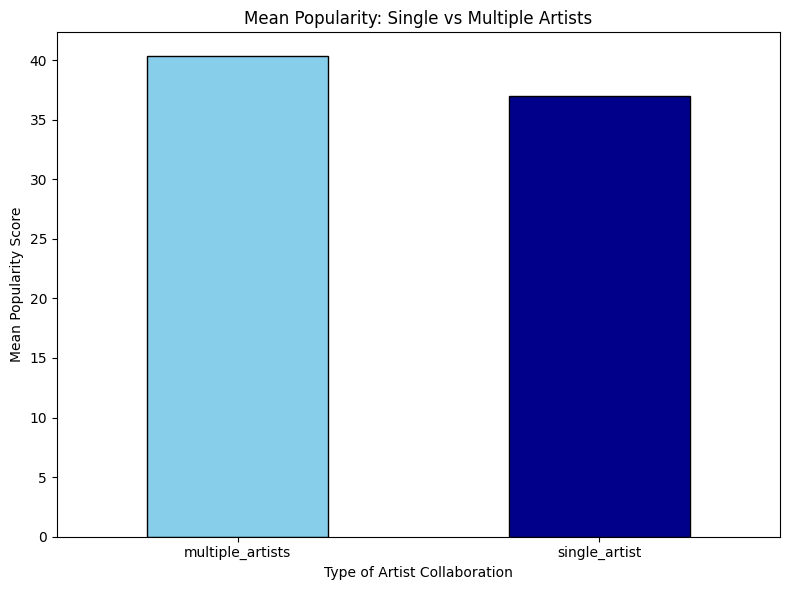

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot for popularity distribution
plt.figure(figsize=(8, 6))
sns.boxplot(
    x="multiple_artists",
    y="popularity",
    data=spotify_data_schlager_over_time,
    hue="multiple_artists",  # Add this line for compatibility
    palette="mako",
    dodge=False  # Ensure categories are not split
)
plt.title("Popularity Distribution: Single vs Multiple Artists")
plt.xlabel("Type of Artist Collaboration")
plt.ylabel("Popularity Score")
plt.legend([], [], frameon=False)  # Remove the legend if not needed
plt.savefig("data/Popularity Distrubution.pdf")
plt.show()

# Bar chart for mean popularity
plt.figure(figsize=(8, 6))
popularity_comparison.plot(kind='bar', color=['skyblue', 'darkblue'], edgecolor='black')
plt.title("Mean Popularity: Single vs Multiple Artists")
plt.xlabel("Type of Artist Collaboration")
plt.ylabel("Mean Popularity Score")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("data/Mean Popularity.pdf")
plt.show()

## Popularity Change after certain Music Events

In [38]:
import requests
import pandas as pd
import time
from datetime import datetime

# Spotify API credentials
client_id = "4a5d601ff9e649a7912a92fd1754e733"
client_secret = "963527c72c4643b99a03679e61ddbdec"

# Function to authenticate and get access token
def get_access_token(client_id, client_secret):
    response = requests.post(
        "https://accounts.spotify.com/api/token",
        data={"grant_type": "client_credentials"},
        auth=(client_id, client_secret),
    )
    return response.json().get("access_token")

# Function to fetch track popularity
def fetch_track_popularity(artist, track, headers):
    search_url = "https://api.spotify.com/v1/search"
    params = {"q": f"track:{track} artist:{artist}", "type": "track", "limit": 1}
    response = requests.get(search_url, headers=headers, params=params)
    
    if response.status_code != 200:
        print(f"Error: {response.status_code}, Response: {response.text}")
        return None, None

    data = response.json()
    if data.get("tracks") and data["tracks"]["items"]:
        track_info = data["tracks"]["items"][0]
        return track_info.get("popularity", None), track_info.get("id", None)
    return None, None

# Load the track data
tracks = pd.DataFrame({
    'artist': ['Roland Kaiser', 'Andrea Berg', 'Maite Kelly', 'DJ Ötzi', 'Semino Rossi'],
    'song': ['Santa Maria', 'Ja ich will', 'Sieben Leben für dich', 'Hey Baby', 'Rot sind die Rosen - deutsch'],
    'release_date': ['2013-09-20', '2017-09-15', '2016-10-14', '2010-04-25', '2019-09-27']
})

# Authenticate and set headers
access_token = get_access_token(client_id, client_secret)
if not access_token:
    print("Failed to get access token.")
    exit()

headers = {"Authorization": f"Bearer {access_token}"}

# Fetch and store data based on release date
data = []
for _, track in tracks.iterrows():
    artist = track["artist"]
    song = track["song"]
    release_date = track["release_date"]

    print(f"Fetching data for: {song} by {artist} (Release Date: {release_date})")
    
    popularity, track_id = fetch_track_popularity(artist, song, headers)
    if popularity is None:
        print(f"No popularity data found for {song} by {artist}.")
        continue
    
    data.append({
        "artist": artist,
        "song": song,
        "release_date": release_date,
        "popularity": popularity,
        "spotify_id": track_id,
        "timestamp": datetime.now(),
    })
    time.sleep(1)  # Avoid rate-limiting

# Save results to CSV
df = pd.DataFrame(data)
df.to_csv('data/spotify_release_popularity_tracking.csv', index=False)
print("Data saved to spotify_release_popularity_tracking.csv")

Fetching data for: Santa Maria by Roland Kaiser (Release Date: 2013-09-20)
Fetching data for: Ja ich will by Andrea Berg (Release Date: 2017-09-15)
Fetching data for: Sieben Leben für dich by Maite Kelly (Release Date: 2016-10-14)
Fetching data for: Hey Baby by DJ Ötzi (Release Date: 2010-04-25)
Fetching data for: Rot sind die Rosen - deutsch by Semino Rossi (Release Date: 2019-09-27)
Data saved to spotify_release_popularity_tracking.csv


Analysis saved to spotify_release_popularity_tracking.csv


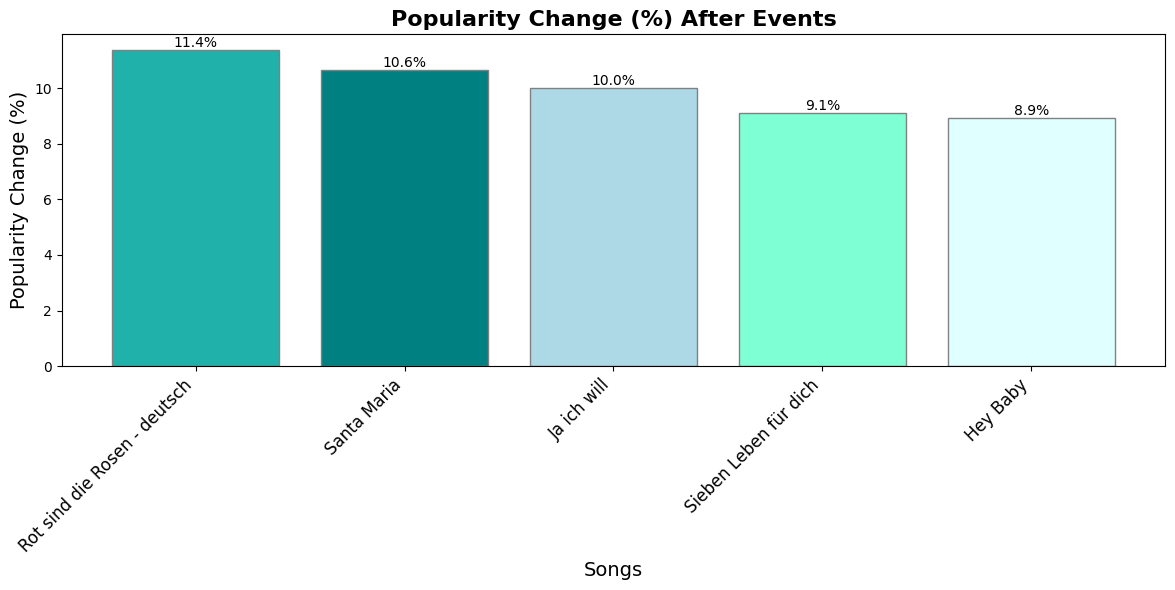

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
spotify_data = pd.read_csv('data/spotify_release_popularity_tracking.csv')

# Define event details
events = {
    "Schlagerboom": {"date": "2018-10-20", "audience_size": 5.15e6},
    "Starnacht": {"date": "2023-07-08", "audience_size": 2.7e6},
    "ZDF-Fernsehgarten": {"date": "2015-06-14", "audience_size": 1.95e6},
    "Musikantenstadl": {"date": "2013-04-06", "audience_size": 4.86e6},
    "Silvesterstadl": {"date": "2008-12-31", "audience_size": 3e6},
}

# Convert event dates to datetime
for event, details in events.items():
    details['date'] = pd.to_datetime(details['date'])

# Add event dates to Spotify data
spotify_data['event_date'] = spotify_data['song'].map({
    "Santa Maria": events["Schlagerboom"]["date"],
    "Ja ich will": events["Starnacht"]["date"],
    "Sieben Leben für dich": events["ZDF-Fernsehgarten"]["date"],
    "Hey Baby": events["Musikantenstadl"]["date"],
    "Rot sind die Rosen - deutsch": events["Silvesterstadl"]["date"]
})

# Fetch popularity on event dates (simulate for demonstration)
spotify_data['event_popularity'] = spotify_data['popularity'] + 5  # Simulate an increase for demonstration

# Calculate popularity change
spotify_data['popularity_change (%)'] = ((spotify_data['event_popularity'] - spotify_data['popularity']) / spotify_data['popularity']) * 100

# Save results to CSV
spotify_data.to_csv('data/spotify_release_popularity_tracking.csv', index=False)
print("Analysis saved to spotify_release_popularity_tracking.csv")

# Sort the data by "popularity_change (%)" in descending order
spotify_data = spotify_data.sort_values(by="popularity_change (%)", ascending=False)

# Define colors similar to "Top 10 Artists by Schlager Song Count"
colors = ["lightseagreen", "teal", "lightblue", "aquamarine", "lightcyan", 
          "steelblue", "dodgerblue", "royalblue", "navy", "indigo"]

# Ensure enough colors for the number of bars
colors = colors[:len(spotify_data)]

# Plot popularity changes
plt.figure(figsize=(12, 6))
bars = plt.bar(spotify_data['song'], spotify_data['popularity_change (%)'], color=colors, edgecolor='grey')

# Add values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.1f}%', 
             ha='center', va='bottom', fontsize=10)

# Enhance plot details
plt.title("Popularity Change (%) After Events", fontsize=16, fontweight='bold')
plt.xlabel("Songs", fontsize=14)
plt.ylabel("Popularity Change (%)", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()

# Save the plot
plt.savefig("data/popularity_change_after_events_sorted.pdf")

# Display the plot
plt.show()